# Hovmoller Diagram Example

The Hovmoller diagram is used to average over an axis (e.g., latitude) to create a time series of values that can be plotted over the remaining spatial axis (e.g., longitude). This method of displaying data was first conceived by Ernest Hovmoller, a Danish meteorologist, in the late 1940's and was done to display the idea of downstream development that emenated from Rossby Wave dynamics. Historically this was done by plotting 500-hPa height values, but is now commonly done using 250-hPa v-component of the wind. Downstream devlopment is exemplified by increasing absolute values of the v-component of the wind as you move forward in time and to the east in space.

The diagram that is constructed in this notebook is an average of the v-component of the wind over the latitude belt from 30 to 70N and has time increasing as you go down the y-axis.

For further explination see Lackman (2011) (the course textbook) page 26-27.

In [1]:
import warnings
warnings.filterwarnings("ignore")

from datetime import datetime

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import metpy.calc as mpcalc
from metpy.constants import earth_avg_radius
from metpy.units import units
import numpy as np
from scipy.ndimage import gaussian_filter
import xarray as xr

## Get the data

Set the time range, parameter, and level to desired values

In [2]:
# Set these values to the range you desire. Currently, all data must be from the same year.
start_time = '2011-01-20'
end_time = '2011-02-15'

time_slice = slice(start_time, end_time)

param = 'vwnd'
level = 250

ds = xr.open_dataset('http://www.esrl.noaa.gov/psd/thredds/dodsC/Datasets/'
                     f'ncep.reanalysis/pressure/{param}.{start_time[:4]}.nc')
ds_ltm = xr.open_dataset('http://www.esrl.noaa.gov/psd/thredds/dodsC/Datasets/ncep.reanalysis.derived/pressure/'
                         f'{param}.4Xday.1981-2010.ltm.nc', decode_times=False)

lat_slice = slice(70, 30)
lon_slice = slice(0,360)

data = ds[param].sel(time=time_slice,
                     level=level,
                     lat=lat_slice,
                     lon=lon_slice)

data_ltm = ds_ltm[param].sel(level=level,
                             lat=lat_slice,
                             lon=lon_slice)[data.time.values.argmin():(data.time.values.argmax()+1)]

In [3]:
lats = ds[param].lat.sel(lat=lat_slice).values
lons = ds[param].lon.sel(lon=lon_slice).values
lats = np.append(lats[0] + (lats[0]-lats[1]), lats)
lons = np.append(lons, lons[-1] + (lons[0]-lons[1]))
lons, lats = np.meshgrid(lons, lats)
dx, dy = mpcalc.lat_lon_grid_deltas(lons, lats)
weights = np.tile((dx[:-1, :].m * dy[:, :-1].m), (data.time.shape[0], 1, 1))

In [4]:
#avg_data = data.mean(dim='lat', kwargs={'weights': weights[data.time.shape[0], :, 0], 'axis':1})
avg_data = np.average(data, axis=1, weights=weights[:data.time.shape[0], :data.lat.shape[0], :])
avg_data_ltm = np.average(data_ltm, axis=1, weights=weights[:data.time.shape[0], :data.lat.shape[0], :])

anomaly_data = avg_data - avg_data_ltm

times = data.time.values
lons = data.lon.values

vtimes = []
for itime in range(len(times)):
    vtimes.append(times[itime].astype('datetime64[ms]').astype('O'))

## Make the Hovmoller Plot

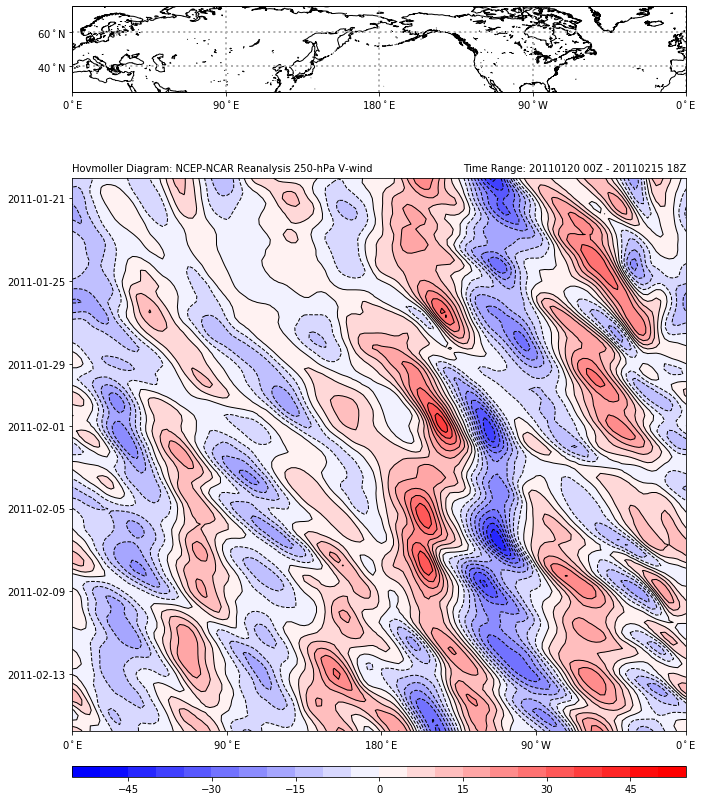

In [5]:
fig = plt.figure(figsize=(11, 16),constrained_layout=True)
gs = gridspec.GridSpec(nrows=2, ncols=1, height_ratios=[1, 7])

ax1 = fig.add_subplot(gs[0,0], projection=ccrs.PlateCarree(central_longitude=180))
ax1.set_extent([0, 357.5, 25, 75], ccrs.PlateCarree(central_longitude=180))
ax1.set_yticks([40, 60])
ax1.set_yticklabels(['40$^\circ$N', '60$^\circ$N'])
ax1.set_xticks([-180, -90, 0, 90, 180])
ax1.set_xticklabels(['0$^\circ$E', '90$^\circ$E', '180$^\circ$E', '90$^\circ$W', '0$^\circ$E'])
ax1.grid(linestyle='dotted', linewidth=2)

# Add geopolitical boundaries for map reference
ax1.add_feature(cfeature.COASTLINE.with_scale('50m'))
ax1.add_feature(cfeature.LAKES.with_scale('50m'), color='black', linewidths=0.5)

ax2 = fig.add_subplot(gs[1,0])
ax2.invert_yaxis()
clevs = range(-50, 51, 5)
#hatches_cf = ['/' if i < 0 else None for i in clevs]
cf = ax2.contourf(lons, times, gaussian_filter(avg_data, sigma=1.0), clevs, cmap=plt.cm.bwr, extend='both')
cs = ax2.contour(lons, times, gaussian_filter(avg_data, sigma=1.0), clevs, colors='k', linewidths=1)
ax2.set_xticks([0, 90, 180, 270, 357.5])
ax2.set_xticklabels(['0$^\circ$E', '90$^\circ$E', '180$^\circ$E', '90$^\circ$W', '0$^\circ$E'])
plt.colorbar(cf, orientation='horizontal', pad=0.05, aspect=50, extendrect=True)
plt.title('Hovmoller Diagram: NCEP-NCAR Reanalysis 250-hPa V-wind', loc='left', fontsize=10)
plt.title('Time Range: {0:%Y%m%d %HZ} - {1:%Y%m%d %HZ}'.format(vtimes[0],vtimes[-1]), loc='right', fontsize=10)

#plt.savefig('hovmoller_{:%Y%m%d%H}_{:%Y%m%d%H}.png'.format(vtimes[0], vtimes[-1]), bbox_inches='tight', dpi=150)

plt.show()